In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
from typing import Any, Dict

import numpy as np
import scipy.sparse as sp
import torch
from jaxtyping import Float, Integer
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

from src.graph_models.csbm import CSBM
from src.models.ntk import NTK
from src.attacks import create_attack
from common import configure_hardware, get_graph, get_diffusion, row_normalize, count_edges_for_idx

In [23]:
# Data
data_dict = dict(
    classes = 2,
    n = 1000,
    #n_per_class_trn = 400
    sigma = 1,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
)
K = 1
seed = 42
# Model
model_dict_gcn = {
    "label": "GCN",
    "model": "GCN",
    "normalization": "row_normalization",
    "depth": 1,
}
model_dict_gcn_tbn = {
    "label": "GCN_TBN",
    "model": "GCN",
    "normalization": "trust_biggest_neighbor",
    "depth": 1,
}
model_dict_gcn_degree_scaling = {
    "label": "GCN_DegScale",
    "model": "GCN",
    "normalization": "degree_scaling",
    "gamma": 1,
    "delta": 0.9,
    "depth": 1,
}
model_dict_softmedoid = {
    "label": "SoftM_T1",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 1
}
model_dict = model_dict_softmedoid
model_dict_l = [model_dict_gcn, model_dict_gcn_tbn, model_dict_gcn_degree_scaling, model_dict_softmedoid]
attack_params = {
    "attack": "random"
}
# Attack
eps_l = [0, 0.01, 0.025, 0.05, 0.10, 0.25, 0.50, 1, 2.5, 5, 10]
# other
device = "cpu"
dtype = torch.float64


In [25]:
ntk_dict = dict()
device_ = configure_hardware(device, seed)
data_dict["K"] = K
for model_dict in model_dict_l:
    # Sample
    X, A, y = get_graph(data_dict, seed=seed)
    X = torch.tensor(X, dtype=dtype, device=device_)
    A = torch.tensor(A, dtype=dtype, device=device_)
    y = torch.tensor(y, device=device_)
    target_idx = np.arange(A.shape[0])
    S = get_diffusion(X, A, model_dict)
    # Init Attack
    attack = create_attack(target_idx, X, A, y, attack_params, seed)
    # Computing NTK
    ntk_l = list()
    for eps in eps_l:
        n_pert = int(round(eps * count_edges_for_idx(A, target_idx)))
        A_pert = attack.attack(n_pert)
        S = get_diffusion(X, A_pert, model_dict)
        ntk_l.append(NTK(X, S, model_dict))
    ntk_dict[model_dict["label"]] = ntk_l

In [21]:
device_ = configure_hardware(device, seed)
data_dict["K"] = K
X, A, y = get_graph(data_dict, seed=seed)
X = torch.tensor(X, dtype=dtype, device=device_)
A = torch.tensor(A, dtype=dtype, device=device_)
y = torch.tensor(y, device=device_)
A_mask = A.detach().clone() * -1
A_mask += 1
A_mask = A_mask.to(torch.bool)
n = A.shape[0]
att_idx = np.array([i for i in range(0, n, 2)]) #torch.Tensor([i for i in range(0, n, 2)]).to(torch.long)
M = torch.zeros((n,n), dtype=torch.bool)
M[att_idx, :] = True
M[:, att_idx] = True
n_class0 = (y==0).sum()
M[:n_class0, n_class0:] = M[:n_class0, n_class0:].logical_and(A_mask[:n_class0, n_class0:])
M[:n_class0, :n_class0] = False
M[n_class0:, n_class0:] = False
triu_idx = torch.triu_indices(n,n,offset=1)
M_triu = M[triu_idx[0, :], triu_idx[1,:]]
row_idx = triu_idx[0,:][M_triu]
col_idx = triu_idx[1,:][M_triu]
print(row_idx.shape[0])
print(col_idx.shape)

187142
torch.Size([187142])


In [70]:
A = torch.Tensor([[1, 0, 1], [0, 1, 1], [1, 1, 1]])
print(A)
deg = torch.Tensor([2, 2, 3]).view(A.shape[0], 1)
delta = 1
gamma = 3
deg_num = deg - delta
deg_den = deg + gamma
print(deg_num)
print(deg_den)
print(deg_num / deg_den)
weight = (deg_num / deg_den).view(-1)
print(weight)
A_x_weight = torch.einsum("ij,j -> ij", A, weight)
print(A_x_weight)
norm = 1 / torch.sum(A_x_weight, axis=1)
print(norm)
S = torch.einsum("ij, i -> ij", A_x_weight, norm)
print(S)

tensor([[1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.]])
tensor([[1.],
        [1.],
        [2.]])
tensor([[5.],
        [5.],
        [6.]])
tensor([[0.2000],
        [0.2000],
        [0.3333]])
tensor([0.2000, 0.2000, 0.3333])
tensor([[0.2000, 0.0000, 0.3333],
        [0.0000, 0.2000, 0.3333],
        [0.2000, 0.2000, 0.3333]])
tensor([1.8750, 1.8750, 1.3636])
tensor([[0.3750, 0.0000, 0.6250],
        [0.0000, 0.3750, 0.6250],
        [0.2727, 0.2727, 0.4545]])


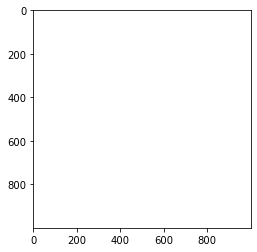

In [39]:
ntk_l = ntk_dict["GCN_TBN"]
ntk = ntk_l[0].get_ntk().detach().cpu().numpy()
fig, ax = plt.subplots()
im = ax.imshow(ntk)


In [26]:
def calc_kernel_means(ntk: NTK, n_class0: int):
    ntk = ntk.get_ntk()
    n = ntk.shape[0]
    mask_class0 = torch.zeros((n,n), dtype=torch.bool)
    mask_class0[:n_class0, :n_class0] = True
    mask_class0 = mask_class0.triu(diagonal=1)
    mask_interclass = torch.zeros((n,n), dtype=torch.bool)
    mask_interclass[:n_class0, n_class0:] = True
    mask_class1 = torch.zeros((n,n), dtype=torch.bool)
    mask_class1[n_class0:, n_class0:] = True
    mask_class1 = mask_class1.triu(diagonal=1)
    avg_class0 = ntk[mask_class0].mean().detach().cpu().item()
    std_class0 = ntk[mask_class0].std().detach().cpu().item()
    avg_class1 = ntk[mask_class1].mean().detach().cpu().item()
    std_class1 = ntk[mask_class1].std().detach().cpu().item()
    avg_interclass = ntk[mask_interclass].mean().detach().cpu().item()
    std_interclass = ntk[mask_interclass].std().detach().cpu().item()
    mask_inclass = mask_class0.logical_or(mask_class1)
    avg_inclass = ntk[mask_inclass].mean().detach().cpu().item()
    std_inclass = ntk[mask_inclass].std().detach().cpu().item()
    m = mask_interclass.sum()
    k = mask_inclass.sum()
    std_diff = torch.sqrt(1 / m * std_interclass**2 + 1/k * std_inclass**2) # upper bound to true std due to ignoriance of (negative) correlation term
    std_diff = std_diff.detach().cpu().item()
    return avg_class0, std_class0, avg_class1, std_class1, \
        avg_interclass, std_interclass, avg_inclass, std_inclass, std_diff



In [270]:
calc_kernel_means(ntk_l[4], n_class0)

(1.5938003942603507,
 0.6115609060501668,
 1.6102559731551527,
 0.5424364046971197,
 1.4250811624752122,
 0.5191984703807301,
 1.6023574930690478,
 0.5767078049134339,
 0.0015528036747127771)

In [13]:
calc_kernel_means(ntk_l[0], n_class0)

NameError: name 'n_class0' is not defined

# Random Adversary

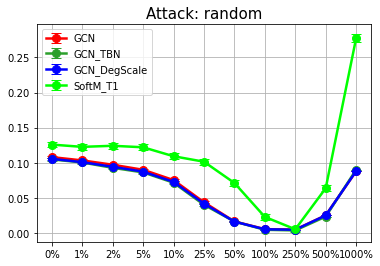

In [27]:
# 1 Layer
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for model_dict in model_dict_l:
    label = model_dict["label"]
    ntk_l = ntk_dict[label]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"{label}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

# Noise Adversary

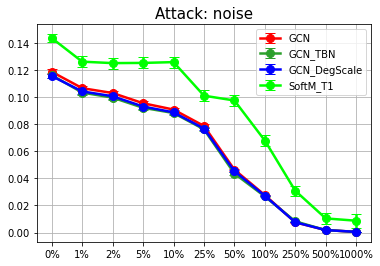

In [90]:
# 1 Layer
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for model_dict in model_dict_l:
    label = model_dict["label"]
    ntk_l = ntk_dict[label]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"{label}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

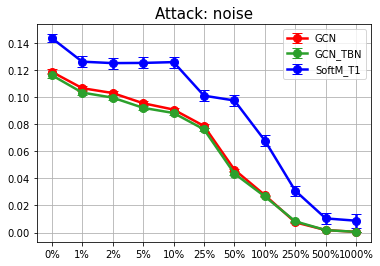

In [51]:
# 1 Layer
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for model_dict in model_dict_l:
    label = model_dict["label"]
    ntk_l = ntk_dict[label]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"{label}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

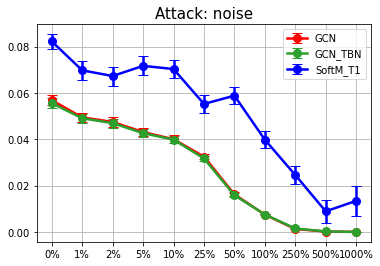

In [54]:
# 2 Layer
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for model_dict in model_dict_l:
    label = model_dict["label"]
    ntk_l = ntk_dict[label]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"{label}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

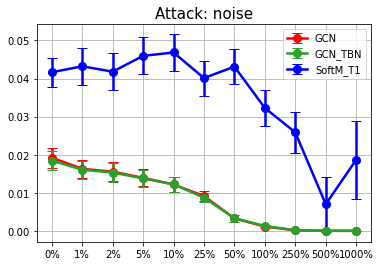

In [57]:
# 4 Layer
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for model_dict in model_dict_l:
    label = model_dict["label"]
    ntk_l = ntk_dict[label]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"{label}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

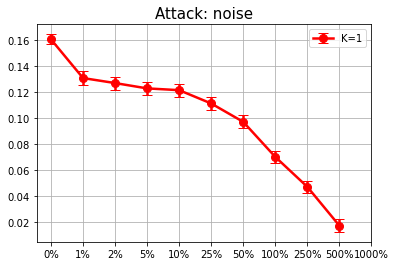

In [24]:
# 2 Layer
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for model_dict in model_dict_l:
    label = model_dict["label"]
    ntk_l = ntk_dict[label]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"{label}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

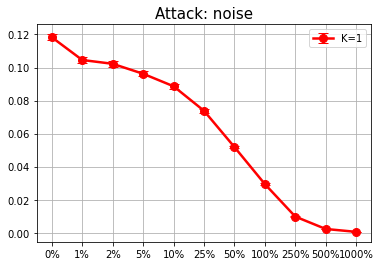

In [29]:
# 2 Layer
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for model_dict in model_dict_l:
    label = model_dict["label"]
    ntk_l = ntk_dict[label]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"{label}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()